# Speech Recognition Neural Network Comparison

## Litha Thampan



---
## Data - Visualizing Audio

The data used in the section is the train-clean section of the LibriSpeech dataset. The index varaible can be changed to visualize different wav files of the data set. 

The following section showcases the Audio Visualiztion of a wav file . The soundfile module provides the amplitude of the audio signal for plotting.soundfile can be used to load Wav file to a floating point time series which can be plotted using matplotlib as below. 

---

In [121]:

from data_viz import AudioVisualizer

viz_obj = AudioVisualizer(index=1)


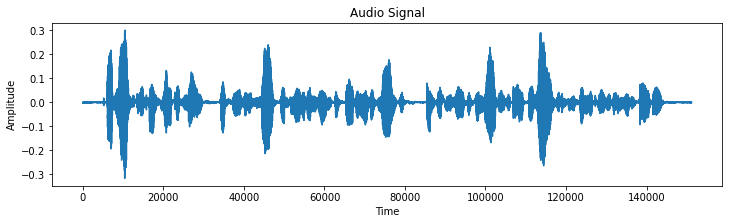

**Shape of Audio Signal** : (151200,)

**Transcript** : at last he sent word to say that he himself would be in england before the end of march and would see that the majesty of the law should be vindicated in his favour

In [122]:
from IPython.display import Audio
from IPython.display import Markdown, display
viz_obj.plot_raw_audio()
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(viz_obj.vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(viz_obj.vis_text)))
# Audio Play 
Audio(viz_obj.vis_audio_path)

---
##  Acoustic Features # 1- Spectrogram

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).The code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech) .The code returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency (which in this case is equal to 161).


---

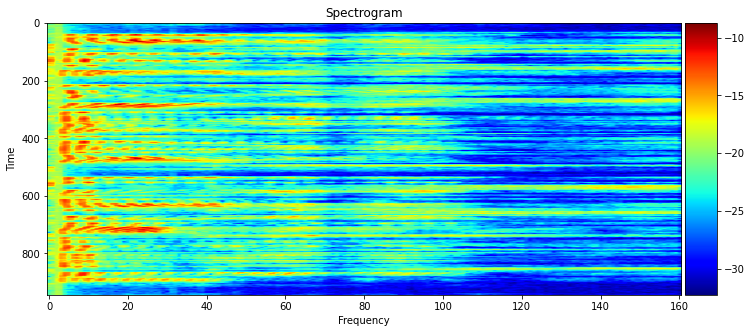

**Shape of Spectrogram** : (944, 161)

In [123]:
viz_obj.plot_spectrogram_feature(normalized = False)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(viz_obj.vis_spectrogram_feature.shape)))

---
##  Normalization 

To speed the convergence of the algorithms, spectrogram is normalized. It can be noted that the mean value hovers around zero, and most entries in the tensor assume values close to zero in the below diagram.


---

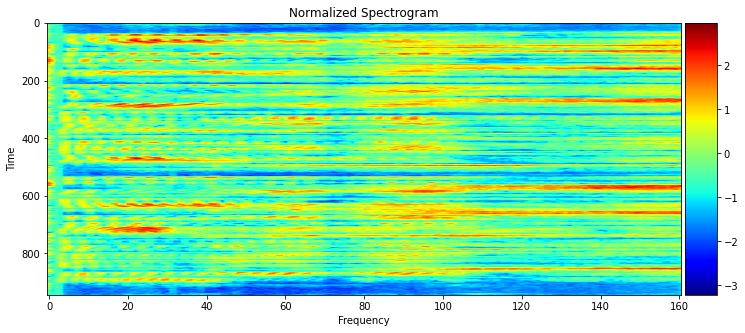

**Shape of Spectrogram** : (944, 161)

In [124]:
viz_obj.plot_spectrogram_feature(normalized = True)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(viz_obj.vis_spectrogram_feature_norm.shape)))

---
##  Acoustic Features # 2- MFCC

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). Details on MFCC can be found in [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional (13) than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

---

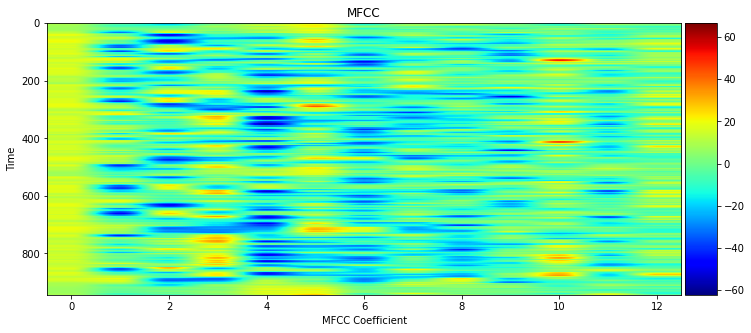

**Shape of MFCC** : (944, 13)

In [125]:
viz_obj.plot_mfcc_feature(normalized=False)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(viz_obj.vis_mfcc_feature.shape)))

---
##  Normalization 

Just like in spectrogram, MFCC is normalized as shown in the below diagram


---

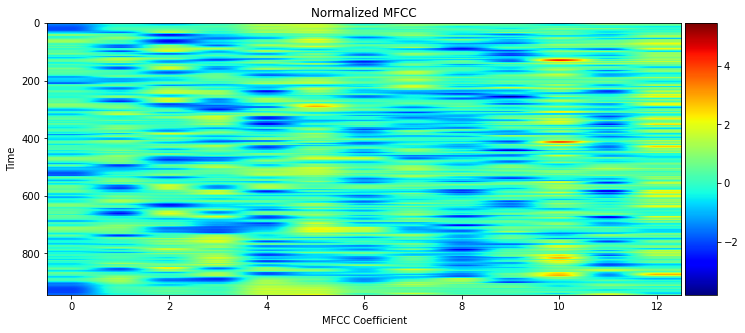

**Shape of MFCC** : (944, 13)

In [126]:
viz_obj.plot_mfcc_feature(normalized=True)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(viz_obj.vis_mfcc_feature_norm.shape)))

---
##  Tensorflow Configurations 

Following section shows tensorflow configurations. Tensorflow 2.0 has done an overhaul of the underlying features so code is significantly different from Tensorflow 1.1.

Active code in the below section is to use CUDA 10.2 GPU with Tensorflow 2.1.0

---

In [7]:
import tensorflow as tf
# For TEnsorflow 1.1 and Keras 2.0.5
'''
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config)
'''            
# For TensofrFlow 2.0

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
tf.config.experimental.set_visible_devices(devices= physical_devices, device_type='GPU')
#tf.config.experimental.set_visible_devices([], 'GPU')  # To use CPU only
# To find out which devices your operations and tensors are assigned to
#tf.debugging.set_log_device_placement(True)
    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
##  Reloaded Modules 

Major modules such as train_util and model_gen constantly go trhough tuning during the training process. So these modules are set as autoreload modules

---

In [8]:

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from model_gen import *
# import function for training acoustic model
from train_utils import train_model


---
##  Simple RNN Models

Given their effectiveness in modeling sequential data ,first set of models contain a single layer of RNNs.
As shown in the figure below, the RNN will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The first such model is Simple RNN which is a fully-connected RNN where the output is to be fed back to input. This has the drawback of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). 

The issue with vanishing gradient was first solved by LSTM([Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory)) RNN. 

Later, GRUs([Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit)) proved to be better in performance among the RNNs. 

All three models are created below and trained using the both spectrogram and MFCC seperately. As it can be observed, all models tends to similar loss component.

From next set onwards, GRUs are used for all RNNs. 


---

In [133]:
simple_mfcc = simple_rnn_model(input_dim=13,cell=SimpleRNN,name='simple_mfcc') # input_dim: 13 for MFCC, 161 for Spectrogram
lstm_mfcc = simple_rnn_model(input_dim=13,cell=LSTM,name='lstm_mfcc') 
gru_mfcc = simple_rnn_model(input_dim=13,cell=GRU,name='gru_mfcc')
simple_spectrogram = simple_rnn_model(input_dim=161,cell=SimpleRNN,name='simple_spectrogram') # input_dim: 13 for MFCC, 161 for Spectrogram
lstm_spectrogram = simple_rnn_model(input_dim=161,cell=LSTM,name='lstm_spectrogram') 
gru_spectrogram = simple_rnn_model(input_dim=161,cell=GRU,name='gru_spectrogram')

Model: "simple_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 29)          1247      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 1,247
Trainable params: 1,247
Non-trainable params: 0
_________________________________________________________________
None
Model: "lstm_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (LSTM)                   (None, None, 29)          4988      
_____________________________

---
The acoustic model is trained with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion. The `train_model` function within the `train_utils` module is used to train the architecture; The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

There are several **optional** arguments that allow you to have more control over the training process.  
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

---

In [135]:
train_model(input_to_softmax=simple_mfcc, 
            pickle_path='simple_mfcc.pickle', 
            save_model_path='simple_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 110s 1s/step - loss: 985.3920 - val_loss: 740.2696
Epoch 2/20
106/106 [==============================] - 117s 1s/step - loss: 758.8722 - val_loss: 725.9455
Epoch 3/20
106/106 [==============================] - 120s 1s/step - loss: 755.5558 - val_loss: 726.1313
Epoch 4/20
106/106 [==============================] - 120s 1s/step - loss: 755.8016 - val_loss: 727.4256
Epoch 5/20
106/106 [==============================] - 121s 1s/step - loss: 754.0231 - val_loss: 721.5045
Epoch 6/20
106/106 [==============================] - 126s 1s/step - loss: 753.2867 - val_loss: 735.1078
Epoch 7/20
106/106 [==============================] - 120s 1s/step - loss: 753.8865 - val_loss: 729.7179
Epoch 8/20
106/106 [==============================] - 125s 1s/step - loss: 753.2357 - val_loss: 730.0334
Epoch 9/20
106/106 [========================

In [155]:
train_model(input_to_softmax=lstm_mfcc, 
            pickle_path='lstm_mfcc.pickle', 
            save_model_path='lstm_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 77s 729ms/step - loss: 952.0212 - val_loss: 780.8254
Epoch 2/20
106/106 [==============================] - 77s 723ms/step - loss: 805.5888 - val_loss: 779.9414
Epoch 3/20
106/106 [==============================] - 77s 730ms/step - loss: 803.3374 - val_loss: 771.7868
Epoch 4/20
106/106 [==============================] - 82s 769ms/step - loss: 803.1780 - val_loss: 779.8071
Epoch 5/20
106/106 [==============================] - 83s 780ms/step - loss: 802.9294 - val_loss: 768.6095
Epoch 6/20
106/106 [==============================] - 83s 787ms/step - loss: 800.5088 - val_loss: 773.5060
Epoch 7/20
106/106 [==============================] - 83s 787ms/step - loss: 792.9408 - val_loss: 756.7023
Epoch 8/20
106/106 [==============================] - 84s 792ms/step - loss: 785.0195 - val_loss: 762.6705
Epoch 9/20
106/106 [========

In [156]:
train_model(input_to_softmax=gru_mfcc, 
            pickle_path='gru_mfcc.pickle', 
            save_model_path='gru_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 78s 739ms/step - loss: 919.5612 - val_loss: 731.0973
Epoch 2/20
106/106 [==============================] - 78s 735ms/step - loss: 755.2492 - val_loss: 732.8497
Epoch 3/20
106/106 [==============================] - 80s 756ms/step - loss: 754.5939 - val_loss: 734.6214
Epoch 4/20
106/106 [==============================] - 81s 760ms/step - loss: 754.5344 - val_loss: 735.3822
Epoch 5/20
106/106 [==============================] - 85s 798ms/step - loss: 753.6231 - val_loss: 715.3268
Epoch 6/20
106/106 [==============================] - 113s 1s/step - loss: 753.0677 - val_loss: 735.5944
Epoch 7/20
106/106 [==============================] - 90s 848ms/step - loss: 751.8974 - val_loss: 730.6780
Epoch 8/20
106/106 [==============================] - 89s 843ms/step - loss: 752.8529 - val_loss: 730.3605
Epoch 9/20
106/106 [==========

In [157]:
train_model(input_to_softmax=simple_spectrogram, 
            pickle_path='simple_spectrogram.pickle', 
            save_model_path='simple_spectrogram.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 50s 470ms/step - loss: 1136.8552 - val_loss: 960.0883
Epoch 2/20
106/106 [==============================] - 49s 462ms/step - loss: 804.2135 - val_loss: 770.1838
Epoch 3/20
106/106 [==============================] - 49s 462ms/step - loss: 795.5692 - val_loss: 725.4524
Epoch 4/20
106/106 [==============================] - 50s 468ms/step - loss: 754.3751 - val_loss: 731.7790
Epoch 5/20
106/106 [==============================] - 49s 461ms/step - loss: 753.7022 - val_loss: 719.9431
Epoch 6/20
106/106 [==============================] - 49s 463ms/step - loss: 753.1860 - val_loss: 734.6483
Epoch 7/20
106/106 [==============================] - 49s 466ms/step - loss: 752.2162 - val_loss: 726.8011
Epoch 8/20
106/106 [==============================] - 49s 462ms/step - loss: 752.8016 - val_loss: 726.7311
Epoch 9/20
106/106 [=======

In [158]:
train_model(input_to_softmax=lstm_spectrogram, 
            pickle_path='lstm_spectrogram.pickle', 
            save_model_path='lstm_spectrogram.h5',
            spectrogram=True) 

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 23s 220ms/step - loss: 934.3874 - val_loss: 749.8531
Epoch 2/20
106/106 [==============================] - 22s 205ms/step - loss: 775.4389 - val_loss: 738.7070
Epoch 3/20
106/106 [==============================] - 21s 202ms/step - loss: 762.6099 - val_loss: 729.9346
Epoch 4/20
106/106 [==============================] - 21s 203ms/step - loss: 755.9970 - val_loss: 733.5358
Epoch 5/20
106/106 [==============================] - 21s 201ms/step - loss: 755.3271 - val_loss: 718.8285
Epoch 6/20
106/106 [==============================] - 21s 202ms/step - loss: 753.5880 - val_loss: 730.4370
Epoch 7/20
106/106 [==============================] - 22s 207ms/step - loss: 753.4633 - val_loss: 730.0255
Epoch 8/20
106/106 [==============================] - 22s 203ms/step - loss: 752.7103 - val_loss: 726.7803
Epoch 9/20
106/106 [========

In [134]:
train_model(input_to_softmax=gru_spectrogram, 
            pickle_path='gru_spectrogram.pickle', 
            save_model_path='gru_spectrogram.h5',
            spectrogram=True)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 49s 462ms/step - loss: 1085.6488 - val_loss: 788.7072
Epoch 2/20
106/106 [==============================] - 22s 209ms/step - loss: 776.4785 - val_loss: 731.2228
Epoch 3/20
106/106 [==============================] - 22s 207ms/step - loss: 759.2929 - val_loss: 737.6945
Epoch 4/20
106/106 [==============================] - 22s 208ms/step - loss: 758.1875 - val_loss: 725.5612
Epoch 5/20
106/106 [==============================] - 22s 210ms/step - loss: 757.6207 - val_loss: 723.8301
Epoch 6/20
106/106 [==============================] - 23s 216ms/step - loss: 756.9144 - val_loss: 733.6155
Epoch 7/20
106/106 [==============================] - 22s 212ms/step - loss: 756.2734 - val_loss: 730.4463
Epoch 8/20
106/106 [==============================] - 22s 212ms/step - loss: 754.3128 - val_loss: 729.9475
Epoch 9/20
106/106 [=======

---
##  RNN + TimeDistributed Dense

 [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer are applied to the GRU RNN model in this section. [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) is added to the recurrent layer to reduce training times.  The `TimeDistributed` layer is used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

---

In [170]:
rnn_mfcc = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu',name='rnn_mfcc')
rnn_spectrogram = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu',name='rnn_spectrogram')

Model: "rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         129000    
_________________________________________________________________
bn_rnn_1d (BatchNormalizatio (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,629
Trainable params: 135,229
Non-trainable params: 400
_________________________________________________________________
None
Model: "rnn_spectrogram"
_________________________________________________________________
Layer (type)        

In [171]:
train_model(input_to_softmax=rnn_mfcc, 
            pickle_path='rnn_mfcc.pickle', 
            save_model_path='rnn_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 125s 1s/step - loss: 294.6564 - val_loss: 430.2307
Epoch 2/20
106/106 [==============================] - 126s 1s/step - loss: 231.3735 - val_loss: 278.6442
Epoch 3/20
106/106 [==============================] - 129s 1s/step - loss: 221.0100 - val_loss: 220.9607
Epoch 4/20
106/106 [==============================] - 128s 1s/step - loss: 215.8551 - val_loss: 209.1163
Epoch 5/20
106/106 [==============================] - 129s 1s/step - loss: 208.8242 - val_loss: 197.9813
Epoch 6/20
106/106 [==============================] - 130s 1s/step - loss: 200.3428 - val_loss: 210.2494
Epoch 7/20
106/106 [==============================] - 131s 1s/step - loss: 189.7685 - val_loss: 180.5462
Epoch 8/20
106/106 [==============================] - 131s 1s/step - loss: 181.2506 - val_loss: 174.6424
Epoch 9/20
106/106 [========================

In [172]:
train_model(input_to_softmax=rnn_spectrogram, 
            pickle_path='rnn_spectrogram.pickle', 
            save_model_path='rnn_spectrogram.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 78s 737ms/step - loss: 315.4469 - val_loss: 259.8323
Epoch 2/20
106/106 [==============================] - 78s 734ms/step - loss: 237.3287 - val_loss: 238.8889
Epoch 3/20
106/106 [==============================] - 78s 738ms/step - loss: 222.8474 - val_loss: 221.5015
Epoch 4/20
106/106 [==============================] - 81s 764ms/step - loss: 213.3212 - val_loss: 210.8598
Epoch 5/20
106/106 [==============================] - 80s 758ms/step - loss: 207.8244 - val_loss: 200.9670
Epoch 6/20
106/106 [==============================] - 80s 755ms/step - loss: 201.6359 - val_loss: 189.0475
Epoch 7/20
106/106 [==============================] - 80s 758ms/step - loss: 190.4671 - val_loss: 181.2795
Epoch 8/20
106/106 [==============================] - 80s 755ms/step - loss: 182.8691 - val_loss: 178.0857
Epoch 9/20
106/106 [========

---
##  CNN + RNN + TimeDistributed Dense


The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.This model is also trained with both MFCC and Spectrogram

---

In [173]:
cnn_rnn_mfcc = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        name='cnn_rnn_mfcc')
cnn_rnn_spectrogram = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        name='cnn_rnn_spectrogram')

Model: "cnn_rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         241200    
_________________________________________________________________
gru_rnn (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)         

In [174]:
train_model(input_to_softmax=cnn_rnn_mfcc, 
            pickle_path='cnn_rnn_mfcc.pickle', 
            save_model_path='cnn_rnn_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 97s 919ms/step - loss: 247.4626 - val_loss: 217.3252
Epoch 2/20
106/106 [==============================] - 97s 911ms/step - loss: 217.1191 - val_loss: 201.6567
Epoch 3/20
106/106 [==============================] - 98s 920ms/step - loss: 196.6221 - val_loss: 185.4140
Epoch 4/20
106/106 [==============================] - 97s 913ms/step - loss: 178.2530 - val_loss: 171.0103
Epoch 5/20
106/106 [==============================] - 96s 906ms/step - loss: 162.0876 - val_loss: 154.2291
Epoch 6/20
106/106 [==============================] - 97s 919ms/step - loss: 148.6175 - val_loss: 148.1755
Epoch 7/20
106/106 [==============================] - 97s 916ms/step - loss: 140.2018 - val_loss: 142.6091
Epoch 8/20
106/106 [==============================] - 99s 929ms/step - loss: 133.1050 - val_loss: 137.3208
Epoch 9/20
106/106 [========

In [175]:
train_model(input_to_softmax=cnn_rnn_spectrogram, 
            pickle_path='cnn_rnn_spectrogram.pickle', 
            save_model_path='cnn_rnn_spectrogram.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 46s 432ms/step - loss: 252.6610 - val_loss: 222.8663
Epoch 2/20
106/106 [==============================] - 43s 407ms/step - loss: 220.0926 - val_loss: 211.4880
Epoch 3/20
106/106 [==============================] - 42s 400ms/step - loss: 212.3430 - val_loss: 204.5167
Epoch 4/20
106/106 [==============================] - 42s 398ms/step - loss: 204.0198 - val_loss: 189.3740
Epoch 5/20
106/106 [==============================] - 42s 395ms/step - loss: 188.8135 - val_loss: 181.6448
Epoch 6/20
106/106 [==============================] - 42s 394ms/step - loss: 174.0647 - val_loss: 166.1766
Epoch 7/20
106/106 [==============================] - 42s 393ms/step - loss: 160.4345 - val_loss: 156.1545
Epoch 8/20
106/106 [==============================] - 41s 390ms/step - loss: 150.1453 - val_loss: 150.3415
Epoch 9/20
106/106 [========

---
##  Deeper RNN + TimeDistributed Dense

The code in `rnn_model` makes use of a single recurrent layer. The architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">


In [176]:
deep_rnn_mfcc = deep_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2,
                         name='deep_rnn_mfcc') 
deep_rnn_spectrogram = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2,
                         name='deep_rnn_spectrogram') 

Model: "deep_rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
gru (GRU)                    (None, None, 200)         129000    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 200)         241200    
_________________________________________________________________
bt_rnn_last_rnn (BatchNormal (None, None, 200)         800       
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)        

In [177]:
train_model(input_to_softmax=deep_rnn_mfcc, 
            pickle_path='deep_rnn_mfcc.pickle', 
            save_model_path='deep_rnn_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 196s 2s/step - loss: 266.4791 - val_loss: 313.9403
Epoch 2/20
106/106 [==============================] - 194s 2s/step - loss: 228.4044 - val_loss: 241.1190
Epoch 3/20
106/106 [==============================] - 194s 2s/step - loss: 220.7054 - val_loss: 213.3568
Epoch 4/20
106/106 [==============================] - 194s 2s/step - loss: 215.6362 - val_loss: 203.6897
Epoch 5/20
106/106 [==============================] - 192s 2s/step - loss: 204.7719 - val_loss: 203.3883
Epoch 6/20
106/106 [==============================] - 194s 2s/step - loss: 179.9132 - val_loss: 169.4541
Epoch 7/20
106/106 [==============================] - 194s 2s/step - loss: 158.5974 - val_loss: 152.6309
Epoch 8/20
106/106 [==============================] - 194s 2s/step - loss: 147.0275 - val_loss: 144.5410
Epoch 9/20
106/106 [========================

In [178]:
train_model(input_to_softmax=deep_rnn_spectrogram, 
            pickle_path='deep_rnn_spectrogram.pickle', 
            save_model_path='deep_rnn_spectrogram.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 140s 1s/step - loss: 289.0370 - val_loss: 236.9812
Epoch 2/20
106/106 [==============================] - 141s 1s/step - loss: 234.9082 - val_loss: 224.1209
Epoch 3/20
106/106 [==============================] - 140s 1s/step - loss: 221.6681 - val_loss: 207.3887
Epoch 4/20
106/106 [==============================] - 139s 1s/step - loss: 210.2110 - val_loss: 202.4899
Epoch 5/20
106/106 [==============================] - 140s 1s/step - loss: 199.8792 - val_loss: 188.9734
Epoch 6/20
106/106 [==============================] - 140s 1s/step - loss: 187.7353 - val_loss: 179.8628
Epoch 7/20
106/106 [==============================] - 140s 1s/step - loss: 174.0346 - val_loss: 168.7872
Epoch 8/20
106/106 [==============================] - 140s 1s/step - loss: 164.8153 - val_loss: 164.3539
Epoch 9/20
106/106 [========================

---
##  Bidirectional RNN + TimeDistributed Dense

[Bidirectional](https://keras.io/layers/wrappers/) wrapper is used in the next architecture model.  This architecture uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">



In [179]:
bidirectional_rnn_mfcc = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                  units=200,
                                  name='bidirectional_rnn_mfcc')
bidirectional_rnn_spectrogram = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200,
                                  name='bidirectional_rnn_spectrogram')

Model: "bidirectional_rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 400)         258000    
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 269,629
Trainable params: 269,629
Non-trainable params: 0
_________________________________________________________________
None
Model: "bidirectional_rnn_spectrogram"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0    

In [180]:
from tensorflow.keras.optimizers import RMSprop,Adam
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.9999, amsgrad=False)
train_model(input_to_softmax=bidirectional_rnn_mfcc, 
            pickle_path='bidirectional_rnn_mfcc.pickle', 
            save_model_path='bidirectional_rnn_mfcc.h5',
            optimizer = optimizer,
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 192s 2s/step - loss: 498.0834 - val_loss: 226.2390
Epoch 2/20
106/106 [==============================] - 192s 2s/step - loss: 229.8353 - val_loss: 219.8411
Epoch 3/20
106/106 [==============================] - 192s 2s/step - loss: 226.2399 - val_loss: 211.1178
Epoch 4/20
106/106 [==============================] - 193s 2s/step - loss: 223.9210 - val_loss: 217.5693
Epoch 5/20
106/106 [==============================] - 191s 2s/step - loss: 221.8741 - val_loss: 208.2536
Epoch 6/20
106/106 [==============================] - 191s 2s/step - loss: 219.4394 - val_loss: 207.8671
Epoch 7/20
106/106 [==============================] - 194s 2s/step - loss: 214.1333 - val_loss: 203.2197
Epoch 8/20
106/106 [==============================] - 193s 2s/step - loss: 209.2849 - val_loss: 198.1799
Epoch 9/20
106/106 [========================

In [181]:
train_model(input_to_softmax=bidirectional_rnn_spectrogram, 
            pickle_path='bidirectional_rnn_spectrogram.pickle', 
            save_model_path='bidirectional_rnn_spectrogram.h5',
            optimizer = optimizer,
            spectrogram=True)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 140s 1s/step - loss: 285.3578 - val_loss: 238.6711
Epoch 2/20
106/106 [==============================] - 139s 1s/step - loss: 232.1645 - val_loss: 218.8618
Epoch 3/20
106/106 [==============================] - 140s 1s/step - loss: 220.9069 - val_loss: 208.2251
Epoch 4/20
106/106 [==============================] - 138s 1s/step - loss: 212.8626 - val_loss: 198.5466
Epoch 5/20
106/106 [==============================] - 139s 1s/step - loss: 190.9364 - val_loss: 173.4232
Epoch 6/20
106/106 [==============================] - 139s 1s/step - loss: 171.1388 - val_loss: 164.2242
Epoch 7/20
106/106 [==============================] - 138s 1s/step - loss: 158.3121 - val_loss: 153.7056
Epoch 8/20
106/106 [==============================] - 138s 1s/step - loss: 149.5190 - val_loss: 147.9222
Epoch 9/20
106/106 [========================

##  Final Model

Based on the observation so far `cnn_rnn_model` seemed to do pretty well.A final model is created with the combination of `cnn_rnn_model` and `deep_rnn_model`. Several hyperparameter tuning is performed to find the best combination to reduce the CTC loss

<img src="images/final_model.png" width="80%">


In [9]:
# specify the model
final_model_mfcc = final_model(input_dim=13,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=250,
                        activation='relu',
                        cell=GRU,
                        dropout_rate=0.5,
                        number_of_layers=2,
                        name='final_model_mfcc')
final_model_spectrogram = final_model(input_dim=161,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=250,
                        activation='relu',
                        cell=GRU,
                        dropout_rate=0.5,
                        number_of_layers=2,
                        name='final_model_spectrogram')

Model: "final_model_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
layer_1_conv (Conv1D)        (None, None, 200)         28800     
_________________________________________________________________
conv_batch_norm (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 250)         339000    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 250)         1000      
_________________________________________________________________
final_layer_of_rnn (GRU)     (None, None, 250)         376500    
_________________________________________________________________
bt_rnn_final (BatchNormaliza (None, None, 250)    

In [185]:
train_model(input_to_softmax=final_model_mfcc, 
            pickle_path='final_light_model_mfcc.pickle',
            save_model_path='final_light_model_mfcc.h5',
            epochs=20,
            spectrogram=False)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 150s 1s/step - loss: 74.9740 - val_loss: 70.0711
Epoch 2/20
106/106 [==============================] - 122s 1s/step - loss: 70.1054 - val_loss: 65.8283
Epoch 3/20
106/106 [==============================] - 123s 1s/step - loss: 66.4465 - val_loss: 67.4600
Epoch 4/20
106/106 [==============================] - 125s 1s/step - loss: 64.4577 - val_loss: 66.0194
Epoch 5/20
106/106 [==============================] - 128s 1s/step - loss: 62.7018 - val_loss: 68.4740
Epoch 6/20
106/106 [==============================] - 128s 1s/step - loss: 61.4306 - val_loss: 68.4914
Epoch 7/20
106/106 [==============================] - 126s 1s/step - loss: 60.3433 - val_loss: 67.1229
Epoch 8/20
106/106 [==============================] - 128s 1s/step - loss: 58.1612 - val_loss: 68.5781
Epoch 9/20
106/106 [==============================] - 130s 1

In [187]:
train_model(input_to_softmax=final_model_spectrogram, 
            pickle_path='final_light_model_spectrogram.pickle',
            save_model_path='final_light_model_spectrogram.h5',
            epochs=20,
            spectrogram=True)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 71s 670ms/step - loss: 82.6190 - val_loss: 74.1305
Epoch 2/20
106/106 [==============================] - 67s 634ms/step - loss: 79.5569 - val_loss: 73.3017
Epoch 3/20
106/106 [==============================] - 68s 643ms/step - loss: 77.1381 - val_loss: 70.9171
Epoch 4/20
106/106 [==============================] - 69s 653ms/step - loss: 75.0380 - val_loss: 73.3451
Epoch 5/20
106/106 [==============================] - 70s 662ms/step - loss: 73.6778 - val_loss: 73.8172
Epoch 6/20
106/106 [==============================] - 71s 671ms/step - loss: 72.5842 - val_loss: 74.2749
Epoch 7/20
106/106 [==============================] - 71s 668ms/step - loss: 71.7616 - val_loss: 73.6476
Epoch 8/20
106/106 [==============================] - 72s 677ms/step - loss: 70.8275 - val_loss: 77.5164
Epoch 9/20
106/106 [========================

In [183]:
train_model(input_to_softmax=final_model_mfcc, 
            train_json='train_corpus_360.json',
            pickle_path='final_model_mfcc.pickle',
            save_model_path='final_model_mfcc.h5',
            epochs=30,
            spectrogram=False)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 1027 steps, validate for 100 steps
Epoch 1/30
1027/1027 [==============================] - 1172s 1s/step - loss: 191.7893 - val_loss: 119.9296
Epoch 2/30
1027/1027 [==============================] - 1233s 1s/step - loss: 140.9578 - val_loss: 100.6770
Epoch 3/30
1027/1027 [==============================] - 1249s 1s/step - loss: 127.9716 - val_loss: 93.6348
Epoch 4/30
1027/1027 [==============================] - 1249s 1s/step - loss: 121.0323 - val_loss: 89.9315
Epoch 5/30
1027/1027 [==============================] - 1240s 1s/step - loss: 115.8791 - val_loss: 91.9054
Epoch 6/30
1027/1027 [==============================] - 1236s 1s/step - loss: 112.2570 - val_loss: 86.4713
Epoch 7/30
1027/1027 [==============================] - 1248s 1s/step - loss: 109.3343 - val_loss: 82.1724
Epoch 8/30
1027/1027 [==============================] - 1251s 1s/step - loss: 106.8012 - val_loss: 79.4474
Epoch 9/30
1027/1027 [===

In [184]:
train_model(input_to_softmax=final_model_spectrogram, 
            train_json='train_corpus_360.json',
            pickle_path='final_model_spectrogram.pickle',
            save_model_path='final_model_spectrogram.h5', 
            epochs=30,
            spectrogram=True)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 1027 steps, validate for 100 steps
Epoch 1/30
1027/1027 [==============================] - 647s 630ms/step - loss: 214.0012 - val_loss: 140.5831
Epoch 2/30
1027/1027 [==============================] - 691s 673ms/step - loss: 162.7523 - val_loss: 116.3759
Epoch 3/30
1027/1027 [==============================] - 688s 670ms/step - loss: 146.7186 - val_loss: 110.8274
Epoch 4/30
1027/1027 [==============================] - 666s 649ms/step - loss: 139.9459 - val_loss: 102.5061
Epoch 5/30
1027/1027 [==============================] - 679s 661ms/step - loss: 133.2192 - val_loss: 100.6474
Epoch 6/30
1027/1027 [==============================] - 670s 653ms/step - loss: 130.6046 - val_loss: 102.2501
Epoch 7/30
1027/1027 [==============================] - 713s 694ms/step - loss: 125.6569 - val_loss: 95.1951
Epoch 8/30
1027/1027 [==============================] - 704s 686ms/step - loss: 123.7147 - val_loss: 98.5245
Epoch

## Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

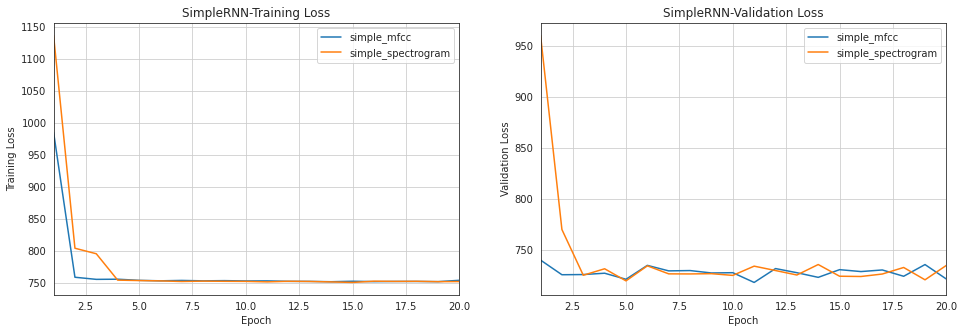

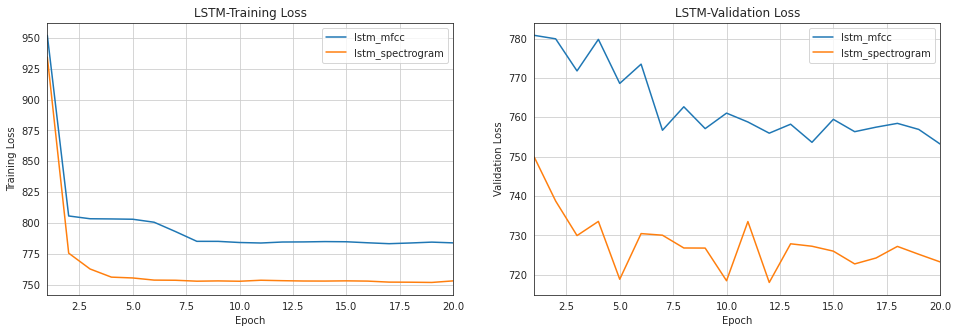

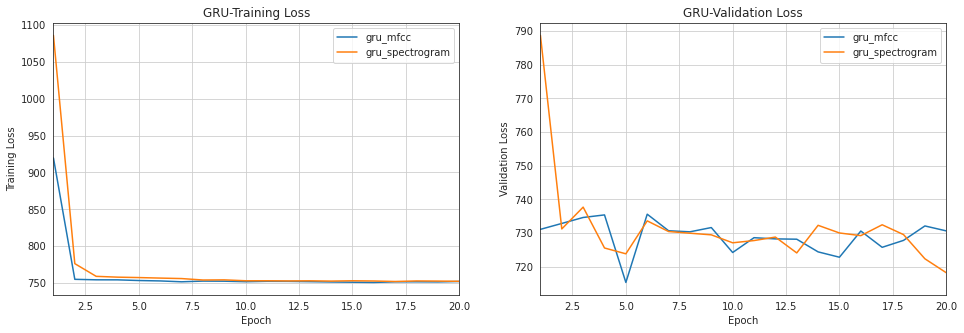

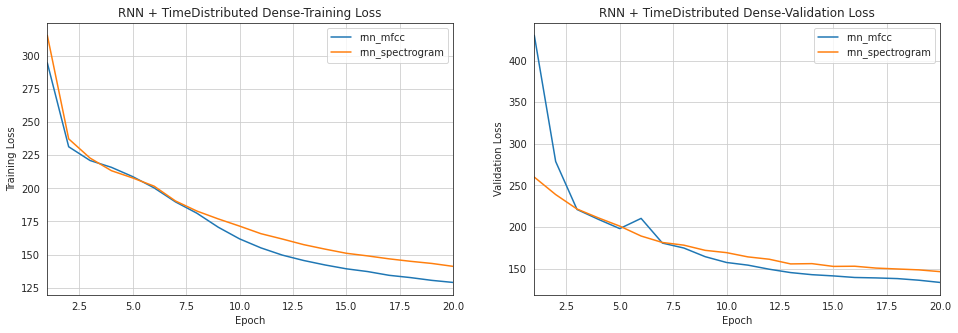

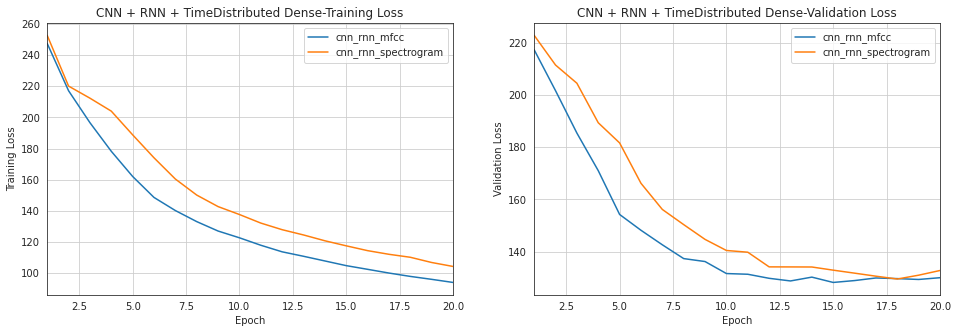

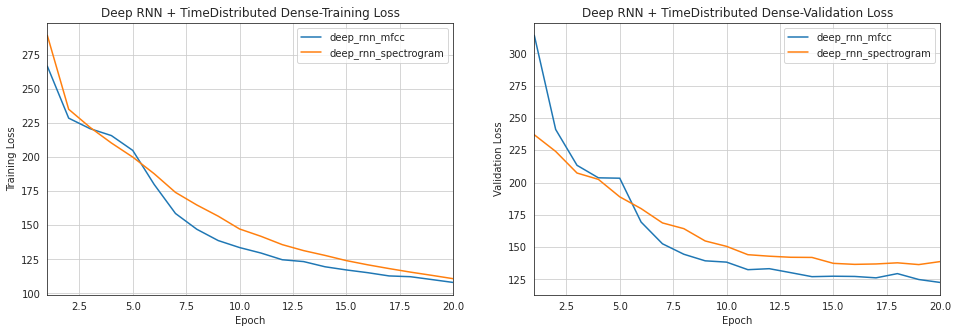

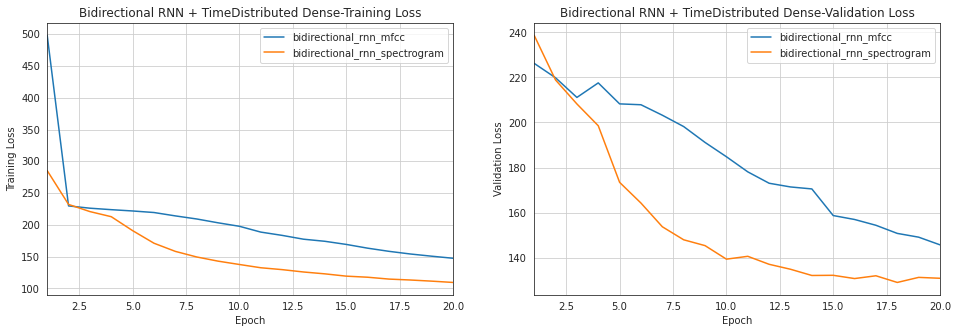

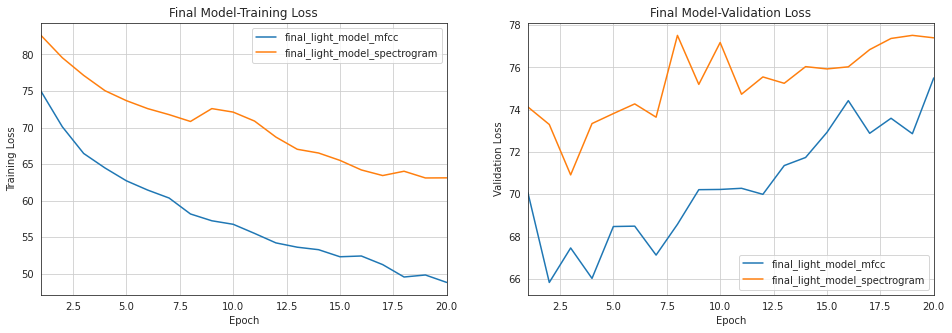

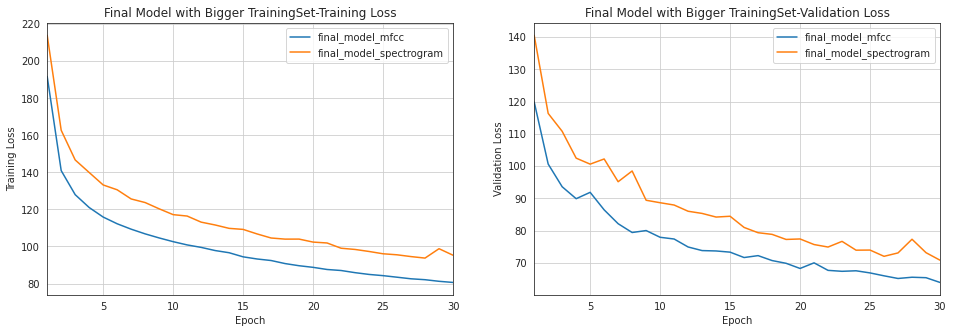

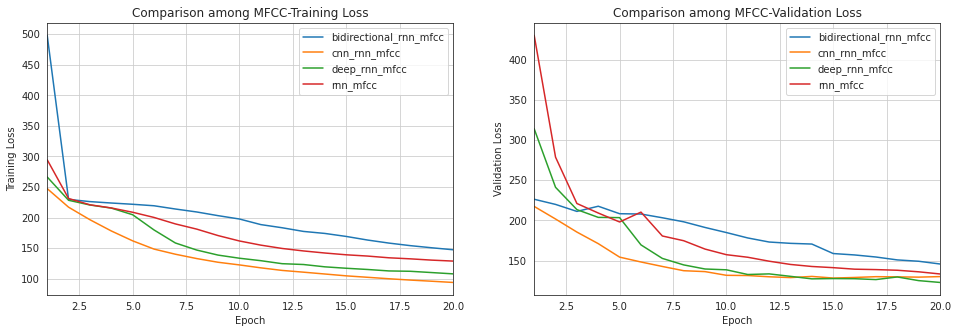

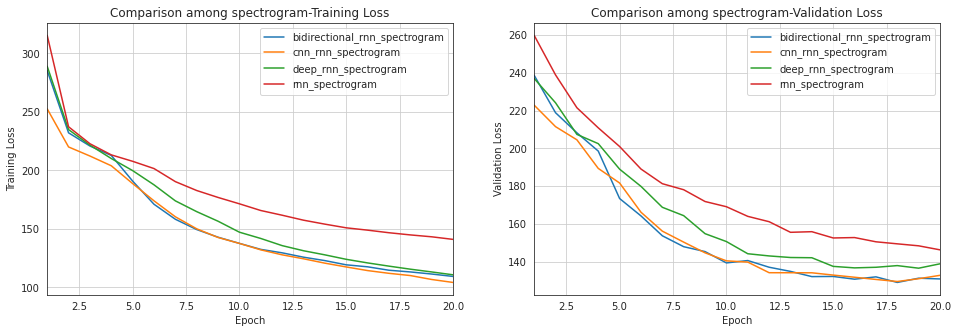

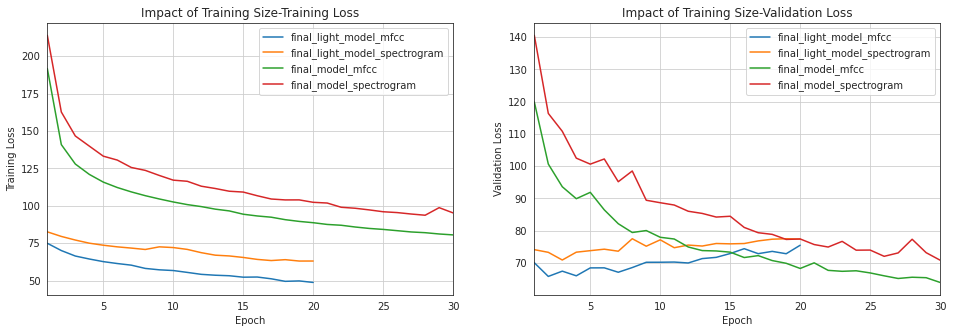

In [6]:
from model_viz import vizualise_model
%matplotlib inline

vizualise_model(listofmodels ="simple_mfcc,simple_spectrogram",title="SimpleRNN")

vizualise_model(listofmodels ="lstm_mfcc,lstm_spectrogram",title="LSTM")

vizualise_model(listofmodels ="gru_mfcc,gru_spectrogram",title="GRU")

vizualise_model(listofmodels ="rnn_spectrogram,rnn_mfcc",title="RNN + TimeDistributed Dense")

vizualise_model(filter="cnn_rnn",title="CNN + RNN + TimeDistributed Dense")

vizualise_model(filter="deep_rnn",title="Deep RNN + TimeDistributed Dense")

vizualise_model(filter="bidir",title="Bidirectional RNN + TimeDistributed Dense")

vizualise_model(filter="final_light_model",title="Final Model")

vizualise_model(listofmodels ="final_model_spectrogram,final_model_mfcc",title="Final Model with Bigger TrainingSet")

vizualise_model(filter ="rnn_mfcc",title="Comparison among MFCC")

vizualise_model(filter ="rnn_spectrogram",title="Comparison among spectrogram")


vizualise_model(filter ="final*model",title="Impact of Training Size")

## Obtain Predictions

The same Librispeech data is used in the below section to obtain predictions and see how the models are converting the speech to texts

In [165]:
from model_use import ModelPredictor
predictor = ModelPredictor(input_to_softmax=final_model_mfcc,model_path='results/final_model_mfcc.h5')
from IPython.display import Audio

# display the true and predicted transcriptions and show the audio file
predictor.get_predictions_index(index=0, 
                partition='validation',                
                spectrogram = False)
print('-'*80)
Audio(predictor.audio_path)

True transcription:

miss lake declined the carriage to night
--------------------------------------------------------------------------------
Predicted transcription:

miss rake to cind te carage to miht
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


## Obtain Live Predictions

A Voice Recording module is implemented to obtain live predictions.The module will record the voice using pyaudio.
It is coded in to automatically stop recording with a threshold amount of silence. Models can be changed to see the live recording predictions

In [169]:
from model_use import ModelPredictor
from IPython.display import Audio
from voice_rec import voice_record

predictor = ModelPredictor(input_to_softmax=final_model_spectrogram,model_path='results/final_model_spectrogram.h5')
# record your voice
voice_record(path='recordings/demo.wav')
# display the true and predicted transcriptions and show the audio file
predictor.get_predictions_recorded(spectrogram = True,recordingpath='recordings/demo.wav')
print('-'*80)
Audio(predictor.audio_path)

please speak into the microphone
done - result written to recordings/demo.wav
--------------------------------------------------------------------------------
Predicted transcription:

nets go
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [161]:
from model_use import ModelPredictor
from IPython.display import Audio
from voice_rec import voice_record

predictor = ModelPredictor(input_to_softmax=final_model_mfcc,model_path='results/final_model_mfcc.h5')
voice_record()
# display the true and predicted transcriptions and show the audio file
predictor.get_predictions_recorded(spectrogram = False,recordingpath='recordings/demo2.wav')
print('-'*80)
Audio(predictor.audio_path)

please speak into the microphone
done - result written to recordings/demo.wav
array([[-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       ...,
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869]])
--------------------------------------------------------------------------------
Predicted transcription:

leks go
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorboard import notebook
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir logs/fit (started 0:00:00 ago; port 6006, pid 23136).
